# Image Captioning - ResNet-LSTM model


This notebook use a ResNet-LSTM model for image captioning


**References**
 
1. Udacity's Computer Vision Nanodegree
2. COCO API: https://github.com/cocodataset/cocoapi
3. This notebook tells how to download the COCO Dataset https://colab.research.google.com/github/rammyram/image_captioning/blob/master/Image_Captioning.ipynb
4. Google's paper using LSTM for image captioning https://arxiv.org/pdf/1411.4555.pdf

**Notes**

This notebook was run on my local machine (Windows, GTX 1050Ti)

## Import Libraries

In [1]:
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
from torchvision import transforms
from torchvision import models
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler, BatchSampler
from torchtext.data.metrics import bleu_score

from PIL import Image
import nltk
nltk.download('punkt')

import sys
sys.path.append("/opt/cocoapi/PythonAPI")

import math
import time
import pickle
import json
import os
import urllib
import zipfile
import random
from tqdm import tqdm
from copy import deepcopy
from collections import Counter

from pycocotools.coco import COCO

# check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

C:\ProgramData\Anaconda3\envs\pytorch-gpu\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\ProgramData\Anaconda3\envs\pytorch-gpu\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PandaEgg\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


cuda


In [118]:
import matplotlib.pyplot as plt

## Vocabulary

We built the vocabulary from the training data set (`captions_train2014.json`).

Implementation of the vocabulary object is adapted from *Udacity Computer Vision Nanodegree*. 

In [2]:
class Vocabulary(object):
    """
    Vocabulary object (Implemented by Udacity)
    """
    def __init__(self, vocab_threshold, vocab_file='/content/vocab.pkl',
                 start_word="<start>", end_word="<end>", unk_word="<unk>",
                 annotations_file="./opt/cocoapi/annotations/captions_train2014.json",
                 vocab_from_file=False):
        """
        Args
            vocab_threshold: minimum count of the words to be considered a unique token
            vocab_file: vocab file
            start_word: start-of-sentence token
            end_word: end-of-sentence token
            unk_word: unknown-word token
            annotations_file: annotations file (for training dataset)
            vocab_from_file: (boolean) whether or not to use the existing vocab file
        """
        self.vocab_threshold = vocab_threshold
        self.vocab_file = vocab_file
        self.start_word = start_word
        self.end_word = end_word
        self.unk_word = unk_word
        self.annotations_file = annotations_file
        self.vocab_from_file = vocab_from_file
        self.get_vocab()

    def get_vocab(self):
        """
        Load/Create the vocab file
        """
        # load and use the existing vocab file
        if os.path.exists(self.vocab_file) & self.vocab_from_file:
            with open(self.vocab_file, 'rb') as f:
                vocab = pickle.load(f)
                self.word2idx = vocab.word2idx
                self.idx2word = vocab.idx2word
            print('Vocabulary successfully loaded from vocab.pkl file!')
        
        # build a new vocab file
        else:
            self.build_vocab()
            with open(self.vocab_file, 'wb') as f:
                pickle.dump(self, f)
    
    def build_vocab(self):
        """
        Create dicts for converting tokens to integers (and vice-versa)
        """
        self.init_vocab()
        self.add_word(self.start_word)
        self.add_word(self.end_word)
        self.add_word(self.unk_word)
        self.add_captions()

    def init_vocab(self):
        """
        Initialize the dictionaries for converting tokens to integers (and vice-versa)
        """
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        """
        Add a token to the vocabulary
        """
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def add_captions(self):
        """
        Loop over training captions and add all tokens to the vocabulary that meet or exceed the threshold
        """
        coco = COCO(self.annotations_file)
        counter = Counter()
        ids = coco.anns.keys()
        for i, id in enumerate(ids):
            caption = str(coco.anns[id]['caption'])
            tokens = nltk.tokenize.word_tokenize(caption.lower())
            counter.update(tokens)

            if i % 100000 == 0:
                print("[%d/%d] Tokenizing captions..." % (i, len(ids)))

        words = [word for word, cnt in counter.items() if cnt >= self.vocab_threshold]

        for i, word in enumerate(words):
            self.add_word(word)

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx[self.unk_word]
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

### Build Vocab File

In [3]:
# minimum count required to add to the vocabulary list
VOCAB_THRESHOLD = 5

# build vocab file from training data
train_vocab = Vocabulary(vocab_threshold=VOCAB_THRESHOLD,
                         vocab_file="./vocab.pkl",
                         start_word="<start>",
                         end_word="<end>",
                         unk_word="<unk>",
                         annotations_file="./opt/cocoapi/annotations/captions_train2014.json",
                         vocab_from_file=False)

loading annotations into memory...
Done (t=0.65s)
creating index...
index created!
[0/414113] Tokenizing captions...
[100000/414113] Tokenizing captions...
[200000/414113] Tokenizing captions...
[300000/414113] Tokenizing captions...
[400000/414113] Tokenizing captions...


## Data Transforms

We create two kinds of datatransforms.

`transform_train` has data augmentation (random crop and random horizontal flip)

`transform_eval` does not have data augmentation at all

In [4]:
# training data transform
transform_train = transforms.Compose([transforms.Resize(256),
                                      transforms.RandomCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

# validation/test data transform
transform_eval = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

## Custom COCO Datasets

There are 2 types of cumstom COCO dataset.

**Dev Mode**

When we loop over the `CoCoDataset_DevMode` dataset, the **processed image tensor** and the **tokenized captions** will be extracted

**Caption Mode**

When we loop over the `CoCoDataset_CaptionMode` dataset, the **original image matrix** (ndarray) and the **processed image tensor** will be extracted

### COCO Dataset (Dev Mode)

In [5]:
class CoCoDataset_DevMode(torch.utils.data.Dataset):
    def __init__(self, transform, batch_size, vocab_file, annotations_file, img_folder):
        """
        Args
            transform: data transform
            batch_size: batch size
            vocab_file: path to the existing vocab file
            annotations_file: annotations file (for training dataset)
            img_folder: path to the images
        """
        # data transform
        self.transform = transform
        # batch size
        self.batch_size = batch_size
        # vocab
        self.vocab = vocab_file
        # image folder
        self.img_folder = img_folder
        # initialize COCO
        self.coco = COCO(annotations_file)
        # annotation ids
        self.ids = list(self.coco.anns.keys())
        print('Obtaining caption lengths...')
        all_tokens = [nltk.tokenize.word_tokenize(str(self.coco.anns[self.ids[index]]['caption']).lower()) for index in tqdm(np.arange(len(self.ids)))]
        self.caption_lengths = [len(token) for token in all_tokens]
        
    def __getitem__(self, idx):
        """
        Get the idx-th item from the dataset
        Returns
            image: processed image
            caption: tokenized caption (including special tokens)
        """
        ann_id = self.ids[idx]
        caption = self.coco.anns[ann_id]['caption']
        img_id = self.coco.anns[ann_id]['image_id']
        path = self.coco.loadImgs(img_id)[0]['file_name']
        # Convert image to tensor and pre-process using transform
        image = Image.open(os.path.join(self.img_folder, path)).convert('RGB')
        image = self.transform(image)
        # Convert caption to tensor of word ids.
        tokens = nltk.tokenize.word_tokenize(str(caption).lower())
        caption = []
        caption.append(self.vocab(self.vocab.start_word))
        caption.extend([self.vocab(token) for token in tokens])
        caption.append(self.vocab(self.vocab.end_word))
        caption = torch.Tensor(caption).long()
        # return pre-processed image and caption tensors
        return image, caption

    def get_data_indices(self):
        # choose a length of the caption
        sel_length = np.random.choice(self.caption_lengths)
        # find all availalbe captions with this length
        all_indices = np.where([self.caption_lengths[i] == sel_length for i in np.arange(len(self.caption_lengths))])[0]
        # select batch_size captions among them
        indices = list(np.random.choice(all_indices, size=self.batch_size))
        return indices

    def __len__(self):
        return len(self.ids)

### Create Dev Mode Dataset for training and validation data

In [6]:
# batch size
BATCH_SIZE = 32

# training dataset for training purposes
dataset_train = CoCoDataset_DevMode(transform=transform_train,  # with augmentation
                                      batch_size=BATCH_SIZE,
                                      vocab_file=train_vocab,
                                      annotations_file="./opt/cocoapi/annotations/captions_train2014.json",
                                      img_folder="./images/train2014/")

training_batch_sampler = BatchSampler(sampler=SubsetRandomSampler(indices=dataset_train.get_data_indices()),
                                      batch_size=dataset_train.batch_size,
                                      drop_last=False)

dataloader_train = DataLoader(dataset=dataset_train, batch_sampler=training_batch_sampler)


# validation dataset for training purposes
dataset_val = CoCoDataset_DevMode(transform=transform_eval,  # no augmentation
                                  batch_size=BATCH_SIZE,
                                  vocab_file=train_vocab,
                                  annotations_file="./opt/cocoapi/annotations/captions_val2014.json",
                                  img_folder="./images/val2014/")

val_batch_sampler = BatchSampler(sampler=SubsetRandomSampler(indices=dataset_val.get_data_indices()),
                                 batch_size=dataset_val.batch_size,
                                 drop_last=False)

dataloader_val = DataLoader(dataset=dataset_val, batch_sampler=val_batch_sampler)

loading annotations into memory...
Done (t=0.69s)
creating index...
index created!
Obtaining caption lengths...


100%|████████████████████████████████████████████████████████████████████████| 414113/414113 [00:43<00:00, 9415.38it/s]


loading annotations into memory...
Done (t=0.35s)
creating index...
index created!
Obtaining caption lengths...


100%|████████████████████████████████████████████████████████████████████████| 202654/202654 [00:21<00:00, 9336.26it/s]


In [7]:
# size of vocab
VOCAB_SIZE = len(dataloader_train.dataset.vocab)
print("VOCAB_SIZE: {}".format(VOCAB_SIZE))

VOCAB_SIZE: 8852


## CNN Encoder

In [8]:
class EncoderCNN(nn.Module):
    """
    Encoder (CNN-based architecture)
    """
    def __init__(self, embed_size):
        """
        Args
            embed_size: (int) dimension of extracted image semantics features
        """
        super(EncoderCNN, self).__init__()
        # load the pre-trained ResNet
        resnet = models.resnet50(pretrained=True)
        # freeze the weights
        for param in resnet.parameters():
            param.requires_grad_(False)
        # grab all CNN layers except the last one
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        # embedding layers
        self.embedding = nn.Linear(resnet.fc.in_features, embed_size)

    def forward(self, images):
        """
        Forward pass
        Args
            images: (tensor) processed image tensor. shape=(batch_size, 3, 224, 224)
        Returns
            feature: (tensor) extracted image semantic features. shape=(batch_size, self.embed_size)
        """
        # resnet stage
        features = self.resnet(images)
        # flatten to 1 dim
        features = features.view(features.size(0), -1)
        # embedding to final feature
        features = self.embedding(features)
        return features

## RNN Decoder

In [9]:
class DecoderRNN(nn.Module):
    """
    Decoder (RNN-based architecture)
    """
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        """
        Args
            embed_size: (int) dimension of extracted image semantics features
            hidden_size: (int) dimension of decoder hidden states
            vocab_size: (int) size of vocabulary
            num_layers: (int) number of decoder layers
        """
        super(DecoderRNN, self).__init__()
        # embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # LSTM layer(s)
        self.lstm = nn.LSTM(input_size=embed_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        # dense layer from hidden states to vocab dimension
        self.fc = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, features, captions):
        """
        Forward pass
        Args
            features: (tensor) encoder output. shape=(batch_size, embed_size)
            captions: (tensor) caption tokens (each element is an int). shape=(batch_size, seq_len)
        Returns
            fc_output: (tensor) final output. shape=(batch, vocab_size)
        """
        # batch size
        batch_size = features.shape[0]
        # embedding dimension
        embed_size = features.shape[1]
        # caption length
        seq_len = captions.shape[1]
        # remove the <end> token
        captions = captions[:, :-1]
        # pass the tokenized captions into the embedding layer
        embedded_captions = self.embedding(captions)  # (batch_size, seq_len-1, embed_size)
        # convert features as the very first tokens
        features = torch.unsqueeze(features, dim=1)  # (batch_size, 1, embed_size)
        # concatenate to obtain lstm_input
        lstm_input = torch.cat((features, embedded_captions), dim=1)  # (batch_size, seq_len, embed_size)
        # LSTM layer
        lstm_output, lstm_hidden = self.lstm(lstm_input)
        # dense layer
        fc_output = self.fc(lstm_output)
        return fc_output
        

    def sample(self, inputs, states=None, max_len=20):
        """
        Decode an image from the embedded feature tensor.
        Args
            inputs: (tensor) embedded image features. shape=(1, 1, embed_size)
            states: (tensor) hidden states of LSTM. shape=(1, hidden_size)
            max_len: (int) maximum length of predicted token list
        Returns
            tokens: (list) a list of tokens predicted by decoder
        """
        tokens = []
        x = inputs
        # output tokens one by one
        for _ in range(max_len):
            # lstm layer
            x, states = self.lstm(x, states)  # (batch_size=1, 1, hidden_size)
            # dense layer
            x = self.fc(x)  # (batch_size=1, 1, vocab_size)
            # token
            tok = torch.argmax(x, dim=-1)  # (batch_size=1, 1)
            # append to the output
            tokens.append(int(tok[0, 0]))
            # early stop (token == 1)
            if tok[0, 0] == 1:
                break
            # embedding
            x = self.embedding(tok)  # (batch_size, 1, embed_size)
        return tokens

## Training Routine

In [158]:
def train_model(model_name, enc, dec, num_epochs, criterion, optimizer, device):
    """
    Train the model
    Args
        model_name: (str) unique name of the model to save
        enc: Pytorch DL model for encoder
        dec: Pytorch DL model for decoder
        num_epochs: number of epochs to train
        criterion: the loss function object
        optimizer: the optimizer
    """
    # number of steps per epoch
    train_steps_per_epoch = math.ceil(len(dataloader_train.dataset.caption_lengths)/dataloader_train.batch_sampler.batch_size)
    val_steps_per_epoch = math.ceil(len(dataloader_val.dataset.caption_lengths)/dataloader_val.batch_sampler.batch_size)
    
    
    # iterate epoch
    for epoch in range(1, num_epochs+1):

        """
        Training
        """
        print("=== Training ===")

        enc.train()
        dec.train()
        
        train_total_loss = 0.0
        train_n = 0

        for step_i in range(1, train_steps_per_epoch+1):
            # sample training indices from dataloader_train
            training_indices = dataloader_train.dataset.get_data_indices()
            # batch sampler
            new_sampler = SubsetRandomSampler(indices=training_indices)
            # load
            dataloader_train.batch_sampler.sampler = new_sampler

            # load inputs
            images_t, captions_t = next(iter(dataloader_train))

            images_t = images_t.to(device)
            captions_t = captions_t.to(device)

            # zero grad
            optimizer.zero_grad()

            # encode
            features_t = enc(images_t)

            # decode
            outputs_t = dec(features_t, captions_t)

            # loss
            loss = criterion(outputs_t.view(-1, VOCAB_SIZE), captions_t.view(-1))

            loss.backward()
            optimizer.step()
            
            train_total_loss += loss.item() * features_t.size(0)
            # number of data seen
            train_n += features_t.size(0)
            # mean loss
            train_mean_loss = train_total_loss / train_n

            # training stats
            stats = "Epoch {}/{}  Step {}/{}\tLoss: {:.4f}  Perplexity: {:.4f}\t[Overall] Loss: {:.4f}\tPerplexity: {:.4f}".format(
                epoch, num_epochs, step_i, train_steps_per_epoch, loss.item(), np.exp(loss.item()), train_mean_loss, np.exp(train_mean_loss))

            # same line print out
            print('\r' + stats, end="")
            sys.stdout.flush()
            
            if step_i == train_steps_per_epoch:
                print('\r' + stats)
            
        """
        Evaluation
        """
        print("=== Evaluation ===")

        enc.eval()
        dec.eval()

        eval_total_loss = 0.0
        eval_n = 0

        for step_i in range(1, val_steps_per_epoch+1):
            # sample indices
            val_indices = dataloader_val.dataset.get_data_indices()
            # subset sampler
            dataloader_val.batch_sampler.sampler = SubsetRandomSampler(indices=val_indices)
            # load inputs
            images_t, captions_t = next(iter(dataloader_val))
            images_t = images_t.to(device)
            captions_t = captions_t.to(device)

            with torch.no_grad():
                # encode
                features_t = enc(images_t)
                # decode
                outputs_t = dec(features_t, captions_t)
                # loss
                loss = criterion(outputs_t.view(-1, VOCAB_SIZE), captions_t.view(-1))
                eval_total_loss += loss.item() * features_t.size(0)
                # number of data seen
                eval_n += features_t.size(0)
                # mean loss
                eval_mean_loss = eval_total_loss / eval_n

            # evaluation stats
            stats = "Epoch {}/{}  Step {}/{}\tLoss: {:.4f}  Perplexity: {:.4f}\t[Overall] Loss: {:.4f}\tPerplexity: {:.4f}".format(
                epoch, num_epochs, step_i, val_steps_per_epoch, loss.item(), np.exp(loss.item()), eval_mean_loss, np.exp(eval_mean_loss))

            # same line print out
            print('\r' + stats, end="")
            sys.stdout.flush()
            
            if step_i == val_steps_per_epoch:
                print('\r' + stats)
            
        # save encoder
        torch.save(enc.state_dict(), os.path.join("./saved_models", "encoder_" + model_name + "_ep" + epoch + ".pth"))
        torch.save(dec.state_dict(), os.path.join("./saved_models", "decoder_" + model_name + "_ep" + epoch + ".pth"))

    return enc, dec

## Create model

In [159]:
## Create encoder
EMBED_SIZE = 512
encoder = EncoderCNN(embed_size=EMBED_SIZE)
print(encoder)

EncoderCNN(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64

In [160]:
## Create decoder
HIDDEN_SIZE = 512
decoder = DecoderRNN(embed_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE, vocab_size=VOCAB_SIZE)
print(decoder)

DecoderRNN(
  (embedding): Embedding(8852, 512)
  (lstm): LSTM(512, 512, batch_first=True)
  (fc): Linear(in_features=512, out_features=8852, bias=True)
)


## Train the Model

In [ ]:
# move to gpu
encoder = encoder.to(device)
decoder = decoder.to(device)

# unique model name for saving the weights
model_name = "020422"

# loss function
criterion = nn.CrossEntropyLoss()

# trainable parameters
params = list(decoder.parameters()) + list(encoder.embedding.parameters())

# optimizer
optimizer = torch.optim.Adam(params, lr=0.001)

# train
encoder, decoder = train_model(model_name, encoder, decoder, num_epochs=5, criterion=criterion, optimizer=optimizer, device=device)

=== Training ===
Epoch 1/5  Step 9335/12942	Loss: 2.1432  Perplexity: 8.5271	[Overall] Loss: 2.5651	Perplexity: 13.001970

## Evaluation - BLEU Score

In [42]:
class CoCoDataset_BLEUMode(torch.utils.data.Dataset):
    def __init__(self, transform, batch_size, vocab_file, annotations_file, img_folder):
        """
        Args
            transform: data transform
            batch_size: batch size
            vocab_file: path to the existing vocab file
            annotations_file: annotations file (for training dataset)
            img_folder: path to the images
        """
        # data transform
        self.transform = transform
        # batch size
        self.batch_size = batch_size
        # vocab
        self.vocab = vocab_file
        # image folder
        self.img_folder = img_folder
        # initialize COCO
        self.coco = COCO(annotations_file)
        # annotation ids
        self.ids = list(self.coco.anns.keys())
        print('Obtaining caption lengths...')
        all_tokens = [nltk.tokenize.word_tokenize(str(self.coco.anns[self.ids[index]]['caption']).lower()) for index in tqdm(np.arange(len(self.ids)))]
        self.caption_lengths = [len(token) for token in all_tokens]
        
    def __getitem__(self, idx):
        """
        Get the idx-th item from the dataset
        Returns
            image: processed image
            caption: tokenized caption (including special tokens)
        """
        ann_id = self.ids[idx]
        caption = self.coco.anns[ann_id]['caption']
        img_id = self.coco.anns[ann_id]['image_id']
        path = self.coco.loadImgs(img_id)[0]['file_name']
        # Convert image to tensor and pre-process using transform
        image = Image.open(os.path.join(self.img_folder, path)).convert('RGB')
        image = self.transform(image)
        # Convert caption to tensor of word ids.
        tokens = nltk.tokenize.word_tokenize(str(caption).lower())
        caption = []
        caption.append(self.vocab(self.vocab.start_word))
        caption.extend([self.vocab(token) for token in tokens])
        caption.append(self.vocab(self.vocab.end_word))
        caption = torch.Tensor(caption).long()
        # return pre-processed image and caption tensors
        return image, caption, img_id

    def get_data_indices(self):
        # choose a length of the caption
        sel_length = np.random.choice(self.caption_lengths)
        # find all availalbe captions with this length
        all_indices = np.where([self.caption_lengths[i] == sel_length for i in np.arange(len(self.caption_lengths))])[0]
        # select batch_size captions among them
        indices = list(np.random.choice(all_indices, size=self.batch_size))
        return indices

    def __len__(self):
        return len(self.ids)

In [43]:
# training dataset for BLEU calculation
single_dataset_train = CoCoDataset_BLEUMode(transform=transform_eval,  # no augmentation
                                           batch_size=1,
                                           vocab_file=train_vocab,
                                           annotations_file="./opt/cocoapi/annotations/captions_train2014.json",
                                           img_folder="./images/train2014/")

single_dataloader_train = DataLoader(dataset=single_dataset_train, batch_size=1, shuffle=False)


# for BLEU calculation
single_dataset_val = CoCoDataset_BLEUMode(transform=transform_eval,  # no augmentation
                                         batch_size=1,
                                         vocab_file=train_vocab,
                                         annotations_file="./opt/cocoapi/annotations/captions_val2014.json",
                                         img_folder="./images/val2014/")

single_dataloader_val = DataLoader(dataset=single_dataset_val, batch_size=1, shuffle=False)

loading annotations into memory...
Done (t=1.50s)
creating index...
index created!
Obtaining caption lengths...


100%|████████████████████████████████████████████████████████████████████████| 414113/414113 [00:52<00:00, 7870.82it/s]


loading annotations into memory...
Done (t=0.57s)
creating index...
index created!
Obtaining caption lengths...


100%|████████████████████████████████████████████████████████████████████████| 202654/202654 [00:24<00:00, 8162.00it/s]


In [17]:
def get_word_list_and_sentence(token_list):
    """
    Given a list of token (ex. [1, 1024, 222, 2]):
        1. remove the <start> token
        2. remove the <end> token and all its following tokens
    And finally return a list of words (ex. ["Hello", "world"]) and the complete sentence (ex. "Hello world")
    Args
        token_list: (list) a list of token integers
    Returns
        word_list: (list) a list of words
        sentence: (str) a str of the words joined by spaces 
    """
    word_list = []

    for tok in token_list:
        # skip the <start> token
        if tok == 0:
            continue
       
        # break if it's an <end> token
        if tok == 1:
            break
        
        # look up the word
        word = train_vocab.idx2word[tok]
        word_list.append(word)
    
    sentence = " ".join(word_list)
    
    return word_list, sentence

In [ ]:
def unique_test(dataloader):
    img_ids = []
    for _, _, img_id in dataloader:
        img_ids.append(img_id.tolist()[0])
    return img_ids

x = unique_test(single_dataloader_val)
print(len(x))
print(len(set(x)))
del x

In [111]:
def eval_BLEU(encoder, decoder, dataloader):
    """
    Evaluate the model on a chosen dataset to calculate the overall BLEU score
    Args
        encoder: (Pytorch model) encoder
        decoder: (Pytorch model) decoder
        dataloader: (Pytorch dataloader) single_dataloader_train OR single_dataloader_val
    Returns
        avg_bleu: (float) average BLEU score
        bleu_list: (list) list of BLEUs scores for all data
    """
    # turn on eval mode and move to GPU
    encoder.eval()
    decoder.eval()
    
    encoder = encoder.to(device)
    decoder = decoder.to(device)
    
    # 
    dict_candidates = dict()
    dict_references = dict()
    
    
    # create a list to store all BLEU scores
    bleu_list = []
    
    cnt = 0
    
    # load (processed image,  caption) one by one (batch_size is 1)
    for image_t, caption_t, img_id in dataloader:
        
        image_t = image_t.to(device)
        caption_t = caption_t.to(device)
        
        img_id = img_id.tolist()[0]  # int
        
        cnt += caption_t.size(0)
        
        with torch.no_grad():
            # encode
            feature_t = encoder(image_t).unsqueeze(1)
            # decode
            token_list = decoder.sample(feature_t)
            
            # convert token list to word list
            decoded_word_list, decoded_sentence = get_word_list_and_sentence(token_list)
            if decoded_sentence not in dict_candidates.get(img_id, []):
                dict_candidates[img_id] = dict_candidates.get(img_id, []) + [decoded_word_list]
            
            # convert captions to word list
            ref_word_list, ref_sentence = get_word_list_and_sentence(caption_t.tolist()[0])
            if ref_sentence not in dict_references.get(img_id, []):
                dict_references[img_id] = dict_references.get(img_id, []) + [ref_word_list]
                
        stats = "[{}/{}] Calculating BLEU scores...".format(cnt, len(dataloader.dataset))
        # same line print out
        print('\r' + stats, end="")
        sys.stdout.flush()

        if cnt == len(dataloader.dataset):
            print('\r' + stats)
            break
    
    # calculate BLEU
    bleu_candidates = []
    bleu_references = []
    for img_id in dict_candidates.keys():
        
        for cancadate in dict_candidates[img_id]:
            bleu_candidates.append(cancadate)
            bleu_references.append(dict_references[img_id])
    
    bleu1 = bleu_score(bleu_candidates, bleu_references, max_n=4, weights=[1.0, 0.0, 0.0, 0.0])
    bleu2 = bleu_score(bleu_candidates, bleu_references, max_n=4, weights=[0.5, 0.5, 0.0, 0.0])
    bleu3 = bleu_score(bleu_candidates, bleu_references, max_n=4, weights=[0.33, 0.33, 0.33, 0.0])
    bleu4 = bleu_score(bleu_candidates, bleu_references, max_n=4, weights=[0.25, 0.25, 0.25, 0.25])
    
    bleu = [bleu1, bleu2, bleu3, bleu4]
    
    return bleu, bleu_candidates, bleu_references


In [113]:
# training dataset
bleu, _, _ = eval_BLEU(encoder, decoder, single_dataloader_train)
print("\n")
print("BLEU Scores: {}".format(bleu))

[414113/414113] Calculating BLEU scores...


Mean validation BLEU Score: [0.6059028567629281, 0.38632562883255395, 0.2504378247199741, 0.1625582778456502]
BLEU Scores: [0.6059028567629281, 0.38632562883255395, 0.2504378247199741, 0.1625582778456502]


In [112]:
# validation dataset
bleu, _, _ = eval_BLEU(encoder, decoder, single_dataloader_val)
print("\n")
print("BLEU Scores: {}".format(bleu))

[202654/202654] Calculating BLEU scores...


Mean validation BLEU Score: [0.6055186931482363, 0.3844462650303808, 0.24774613448862315, 0.15984731769752322]
BLEU Scores: [0.6055186931482363, 0.3844462650303808, 0.24774613448862315, 0.15984731769752322]


## Generate Captions for Test Dataset

In [114]:
class CoCoDataset_CaptionMode(torch.utils.data.Dataset):
    def __init__(self, transform, batch_size, vocab_file, annotations_file, img_folder):
        """
        Args
            transform: data transform
            batch_size: batch size
            vocab_file: path to the existing vocab file
            annotations_file: annotations file (for training dataset)
            img_folder: path to the images
        """
        # data transform
        self.transform = transform
         # batch size
        self.batch_size = batch_size
        # vocab
        self.vocab = vocab_file
        # image folder
        self.img_folder = img_folder
        # path
        test_info = json.loads(open(annotations_file).read())
        self.paths = [item['file_name'] for item in test_info['images']]
        
    def __getitem__(self, idx):
        """
        Get the idx-th item from the dataset
        Returns
            orig_image: original image
            image: preprocessed image
        """
        path = self.paths[idx]
        # Convert image to tensor and pre-process using transform
        PIL_image = Image.open(os.path.join(self.img_folder, path)).convert('RGB')
        orig_image = np.array(PIL_image)
        image = self.transform(PIL_image)
        # return original image and pre-processed image tensor
        return orig_image, image

    def __len__(self):
        return len(self.paths)

In [115]:
# for captioning demo
single_dataset_test = CoCoDataset_CaptionMode(transform=transform_eval,
                                              batch_size=1,
                                              vocab_file=train_vocab,
                                              annotations_file="./opt/cocoapi/annotations/image_info_test2014.json",
                                              img_folder="./images/test2014/")

dataloader_test = DataLoader(dataset=single_dataset_test, batch_size=1, shuffle=True)

In [135]:
def random_sample_testdata(dataloader, encoder, decoder):
    """
    Random sample an image from the test data and generate the caption along with it
    Args
        dataloader: (Pytorch dataloader) the test dataloader (batch_size = 1)
    """
    encoder.eval()
    decoder.eval()
    encoder = encoder.to(device)
    decoder = decoder.to(device)
    
    # sample an image
    orig_image, image_t = next(iter(dataloader))
    image_t = image_t.to(device)
    
    # plot the original image
    plt.imshow(orig_image[0])
    plt.axis('off')
    
    # caption prediction
    with torch.no_grad():
        features_t = encoder(image_t).unsqueeze(1)
        token_list = decoder.sample(features_t)
        
    decoded_word_list, decoded_sentence = get_word_list_and_sentence(token_list)
    
    print(decoded_sentence)

a stop sign with a sticker on it


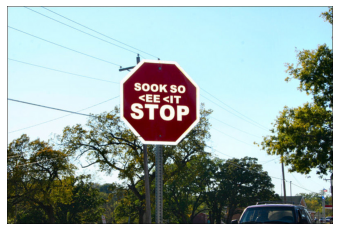

In [155]:
# sample an image
random_sample_testdata(dataloader_test, encoder, decoder)

a bus is driving down the street in the snow .


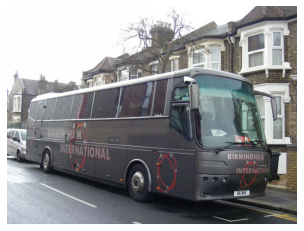

In [152]:
# sample an image
random_sample_testdata(dataloader_test, encoder, decoder)

a kitchen with a stove , refrigerator , and cabinets .


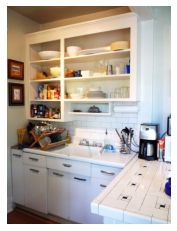

In [139]:
# sample an image
random_sample_testdata(dataloader_test, encoder, decoder)

## Generate Captions for Custom Image

In [141]:
def image_captioning_custom_image(img_path, encoder, decoder):
    """
    Generate a caption for a custom image
    Args
        img_path: (str) path to the image
    """
    encoder.eval()
    decoder.eval()
    encoder = encoder.to(device)
    decoder = decoder.to(device)
    # image preprocessing
    orig_image = np.array(Image.open(img_path).convert('RGB'))
    # plot the original image
    plt.imshow(orig_image)
    plt.axis('off')
    
    # caption prediction
    image_t = transform_eval(Image.open(img_path).convert('RGB'))
    image_t = torch.unsqueeze(image_t, 0)
    image_t = image_t.to(device)
    with torch.no_grad():
        features_t = encoder(image_t).unsqueeze(1)
        token_list = decoder.sample(features_t)
    decoded_word_list, decoded_sentence = get_word_list_and_sentence(token_list)
    print(decoded_sentence)

a cat is sitting on a bed with a laptop .


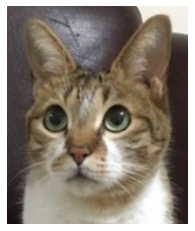

In [142]:
# example custom image
image_captioning_custom_image("./custom_test_images/IMG_2952.jpg", encoder, decoder)

a plate of food with a fork and knife on it .


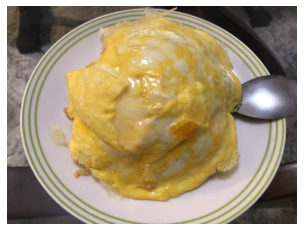

In [143]:
# example custom image
image_captioning_custom_image("./custom_test_images/IMG_4191.jpg", encoder, decoder)

a plate of food with a fork and knife on it .


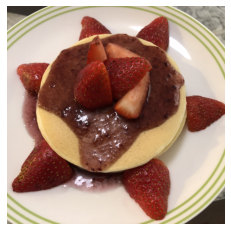

In [144]:
# example custom image
image_captioning_custom_image("./custom_test_images/IMG_4380.jpg", encoder, decoder)

a cat is sitting on a bed with a stuffed animal .


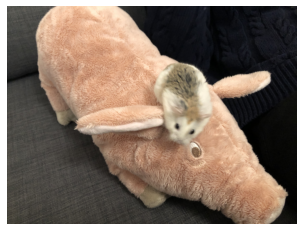

In [145]:
# example custom image
image_captioning_custom_image("./custom_test_images/IMG_4446.jpg", encoder, decoder)